In [1]:
%matplotlib inline
import os 
import sys
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
import math 
from outliers import smirnov_grubbs as grubbs

plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

datadir       = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM/FEB17'
mrsdir        = '/Users/kanaan/SCR/Dataframes_20150820/REVISION_DF'
clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'
savefigdir    = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python'

measures = ['Caud_Puta', 'Thal', 'SN', 'STN', 'RN',  'DN', #'hippo_subiculum', 'hippo_presubbiculum','hippo_CA1'
             'Pall',#'GPi','GPe',
           ]
bigmasks = ['BrainStem','BasalGanglia', 'ALL_NUCLEI' ]

#measures= ['L_' + i for i in measures]
#bigmasks= ['L_' + i for i in bigmasks]


drop_c = ['WSKT','SC1T','LL5T', 'GSAT'] 
# WSKT,SC1T,LL5T Young Females scanned extra for MRS review. They shouldnt be here. 
# GSAT removed since HSPP female removed 
drop_p = ['AA8P', 'RA9P', 'STDP','NL2P','HSPP', 'DF2P', 'CB4P', 'HHQP', 'RMJP'] 

# AA8P motion outliers via mehalonobis distance for Quality metrics 
# STDP','NL2P','HSPP', 'DF2P' – mehalonobis distance for QSM measures Above 

'''Mahalanobis distances: these measure the influence of a case by examining the distance of cases from the mean(s) 
of the predictor variable(s). One needs to look for the cases with the highest values. It is not easy to establish 
a cut-off point at which to worry, although Barnett and Lewis (1978) have produced a table of critical values dependent
on the number of predictors and the sample size. From their work it is clear that even with large samples (N = 500) 
and  five predictors, values above 25 are cause for concern. In smaller samples (N = 100) and with fewer predictors 
(namely, three) values greater than 15 are problematic, and in very small samples (N = 30) with only two predictors 
values greater than 11 should be examined. However, for more specic advice, refer to Barnett and Lewis’s (1978) table'''

'Mahalanobis distances: these measure the influence of a case by examining the distance of cases from the mean(s) \nof the predictor variable(s). One needs to look for the cases with the highest values. It is not easy to establish \na cut-off point at which to worry, although Barnett and Lewis (1978) have produced a table of critical values dependent\non the number of predictors and the sample size. From their work it is clear that even with large samples (N = 500) \nand  five predictors, values above 25 are cause for concern. In smaller samples (N = 100) and with fewer predictors \n(namely, three) values greater than 15 are problematic, and in very small samples (N = 30) with only two predictors \nvalues greater than 11 should be examined. However, for more specic advice, refer to Barnett and Lewis\xe2\x80\x99s (1978) table'

In [2]:
def get_all_dfs(img, population, study_id, trt=False):
    quant = 'median'
    QSM = pd.read_csv(os.path.join(datadir, '%s_%s_%s_%s.csv'%(img, quant, population, study_id)),index_col = 0)
    QSM['Gender']  = QSM['Gender'].map({' F': 1, ' M': 0})
    
    CLN = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_a.csv'%(population)), index_col=0)
    CLN.columns = ['CLN_' + str(col) for col in CLN.columns]    

    def get_mrs(vox):
        if trt == False:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%(vox, population, study_id)),index_col = 0)
        elif trt == True:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_trt_%s.csv'%(vox, population, study_id)),index_col = 0)
        df.columns = ['%s_'%vox + str(col) for col in df.columns]
        return df
    df = pd.concat([QSM, get_mrs('STR'), CLN], axis=1, join_axes=[QSM.index])
    df['L_Caud_Puta']    = (df['L_Puta'] + df['L_Caud']) / 2
    df['R_Caud_Puta']    = (df['R_Puta'] + df['R_Caud']) / 2
    df['Caud_Puta']      = (df['L_Caud_Puta'] + df['R_Caud_Puta']) / 2
    df['L_BrainStem']    = (df['L_STN'] + df['L_SN'] +  df['L_RN']) / 3
    df['R_BrainStem']    = (df['R_STN'] + df['R_SN'] +  df['R_RN']) / 3
    df['L_BasalGanglia'] = (df['L_Puta'] + df['L_Caud'] +  df['L_Pall'] ) / 3
    df['R_BasalGanglia'] = (df['R_Puta'] + df['R_Caud'] +  df['R_Pall'] ) / 3
    df['L_ALL_NUCLEI'] = (df['L_BrainStem'] + df['L_BasalGanglia'] + df['L_DN']) / 3
    df['R_ALL_NUCLEI'] = (df['R_BrainStem'] + df['R_BasalGanglia'] + df['R_DN']) / 3
    df['ALL_NUCLEI'] = (df['BrainStem'] + df['BasalGanglia']) /3
    return df

controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
#patients_b = get_all_dfs('QSM', 'patients', 'b', trt=True)#.drop(drop_p, axis = 0) 



In [3]:
dfxx = pd.concat([controls_a,patients_a ], axis=0)

# Run QSM Statistical modeling

In [4]:
# Compare the groups by modeling GROUP, AGE, GENDER, EFC and FD in a multiple linear regression model as in (Schmaal, Mol Psych, 2015)
# Need to ensure normality of data and  homogeneity of Variance
## Normality is assessed via the Kolmogrov-Smirnov Test for each sample independently.
    ## http://stats.stackexchange.com/questions/57885/how-to-interpret-p-value-of-kolmogorov-smirnov-test-python
## Homogeneity of Variance is assessed via Levenes Test
## Effect size is calculated with Cohen’s d-metric.

In [5]:
def cohen_d(df1,df2, metabolite):
    x = df1[metabolite].dropna(axis=0)
    y = df2[metabolite].dropna(axis=0)
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)

def grubbs_outliers(df, measure, alpha = 0.05):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 

def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def calc_confidence_95(df1,df2, metabolite):
    import numpy as np, statsmodels.stats.api as sms
    X1 = df1[metabolite].dropna(axis=0)
    X2 = df2[metabolite].dropna(axis=0)
    cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
    return cm.tconfint_diff(usevar='pooled')

def make_statistical_comparison(df_controls, df_patients, stat, measures = measures, grubbs = False, ESD = False):
    df_controls['Population'] = 0
    df_patients['Population'] = 1
    cols = ['N','Controls', 'Patients','Levene','KS', 'KS_C', 'KS_P','D','CI_95', 'Statistic', 'p_val', 'p_fdr', 'sig']
    dfs = pd.DataFrame(index= cols, columns=measures)
    
    if grubbs:
        for measure in measures:
            grubbs_controls = grubbs_outliers(df_controls, measure)
            grubbs_patients = grubbs_outliers(df_patients, measure)
            print 'GRUBBS OUTLIERS=', measure, grubbs_controls, grubbs_patients
            for subject in grubbs_controls :
                df_controls.ix[subject,measure] = np.nan
            for subject in grubbs_patients :
                df_patients.ix[subject,measure] = np.nan
    elif ESD:
        for measure in measures:
            grubbs_controls = gESD_outliers(df_controls, measure)
            grubbs_patients = gESD_outliers(df_patients, measure)
            print 'gESD OUTLIERS=', measure, grubbs_controls, grubbs_patients
            for subject in grubbs_controls :
                df_controls.ix[subject,measure] = np.nan
            for subject in grubbs_patients :
                df_patients.ix[subject,measure] = np.nan
        
    df = pd.concat([df_controls, df_patients])
    for measure in measures:
        if stat == 'MR':
            formula = '%s ~ Population + Age + Gender'%measure
            model   = smf.ols(formula=formula, data = df)
            fit     = model.fit()
            p_val   = np.round(fit.pvalues[1],5)
            t_val   = np.round(fit.tvalues[1],3)
        
        elif stat == 'MW':
            
            t_val, p_val = mannwhitneyu(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        elif stat == 'TT':
            t_val, p_val = ttest_ind(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        ci95 = calc_confidence_95(df_controls, df_patients, measure)
        xval = 1000
        npr  = 4
        dfs.ix['N'][measure] = len(df_controls[measure].dropna()), len(df_patients[measure].dropna())
        dfs.ix['Levene'][measure] = np.round(levene(df_controls[measure].dropna(), df_patients[measure].dropna())[1],5)
        dfs.ix['KS'][measure] = np.round(ks_2samp((df_controls[measure].dropna()), 
                                                  (df_patients[measure].dropna()))[1], 5)
        dfs.ix['KS_C'][measure] = np.round(kstest((df_controls[measure].dropna()), 'norm')[1],5)
        dfs.ix['KS_P'][measure] = np.round(kstest((df_patients[measure].dropna()), 'norm')[1],25)
        dfs.ix['D'][measure]    = cohen_d(df_controls, df_patients,measure)
        dfs.ix['Controls'][measure] = '%s±%s'%(xval*np.round(np.mean(df_controls[measure]),npr), 
                                              xval*np.round(np.std(df_controls[measure]), npr))   
        dfs.ix['Patients'][measure] = '%s±%s'%(xval*np.round(np.mean(df_patients[measure]),npr), 
                                              xval*np.round(np.std(df_patients[measure]), npr))   
        dfs.ix['D'][measure]    = np.round(cohen_d(df_controls, df_patients,measure),2)
        dfs.ix['CI_95'][measure]= '%s to %s'%(np.round(ci95[0],2), np.round(ci95[1],2))
        dfs.ix['Statistic'][measure]= np.round(t_val,4)        
        dfs.ix['p_val'][measure]    = np.round(p_val,5)
        
        if p_val < 0.05:
            print measure, 'p =', np.round(p_val,3)
    
    dfs = dfs.T.sort_values('p_val')
    dfs['p_fdr'] = fdrcorrection0(dfs.p_val)[1]
    dfs['sig'] = fdrcorrection0(dfs.p_val)[0]
    return dfs, df 

In [6]:
controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
bgs, bg = make_statistical_comparison(controls_a, patients_a, 'MW', measures=bigmasks, ESD=0)
bgs

BrainStem p = 0.002
BasalGanglia p = 0.027
ALL_NUCLEI p = 0.001


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
ALL_NUCLEI,"(22, 19)",44.7±9.1,33.2±10.0,0.61223,0.00286,1e-05,4.87815e-05,1.18,0.01 to 0.02,87,0.00075,0.00225,True
BrainStem,"(22, 19)",114.6±23.8,89.5±23.6,0.7972,0.01602,0,2.29605e-05,1.03,0.01 to 0.04,95,0.0015,0.00225,True
BasalGanglia,"(22, 19)",19.6±9.4,10.1±11.6,0.03801,0.01123,1e-05,7.65406e-05,0.88,0.0 to 0.02,135,0.02733,0.02733,True


In [7]:
controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
X, XX = make_statistical_comparison(controls_a, patients_a, 'MW', measures = measures, ESD=0)
X

Caud_Puta p = 0.016
SN p = 0.011
STN p = 0.001
RN p = 0.02


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
STN,"(22, 19)",80.3±24.2,51.7±27.6,0.51589,0.0036,1e-05,6.29612e-05,1.08,0.01 to 0.05,88,0.00082,0.00574,True
SN,"(22, 19)",132.7±23.3,113.6±29.2,0.4358,0.06904,0,1.89394e-05,0.71,0.0 to 0.04,121,0.01108,0.0351225,True
Caud_Puta,"(22, 19)",8.7±13.1,-1.0±10.8,0.82993,0.07499,2e-05,8.77482e-05,0.79,0.0 to 0.02,126,0.01551,0.0351225,True
RN,"(22, 19)",130.7±45.1,103.2±34.1,0.44223,0.03436,1e-05,2.63552e-05,0.67,0.0 to 0.05,130,0.02007,0.0351225,True
Pall,"(22, 19)",82.8±17.4,72.6±18.5,0.57789,0.2689,0,3.14564e-05,0.56,-0.0 to 0.02,151,0.06638,0.092932,False
DN,"(22, 19)",70.3±34.2,52.4±47.4,0.21124,0.24411,2e-05,0.000128903,0.42,-0.01 to 0.04,161,0.10714,0.124997,False
Thal,"(22, 19)",-37.1±11.8,-38.8±14.0,0.25,0.32384,1e-05,5.78337e-05,0.13,-0.01 to 0.01,189,0.30509,0.30509,False


In [8]:
controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
X, XX = make_statistical_comparison(controls_a, patients_a, 'MW', measures = ['L_GPi','L_GPe'], ESD=0)
X

L_GPi p = 0.026
L_GPe p = 0.029


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
L_GPi,"(22, 19)",100.6±24.4,85.5±22.6,0.7791,0.11159,0,2.60126e-05,0.62,-0.0 to 0.03,134,0.02572,0.02902,True
L_GPe,"(22, 19)",95.9±15.2,83.3±21.8,0.11024,0.02481,0,2.71451e-05,0.65,0.0 to 0.02,136,0.02902,0.02902,True


In [9]:
controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
X, XX = make_statistical_comparison(controls_a, patients_a, 'MW', measures = ['R_GPi','R_GPe'], ESD=0)
X

,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
R_GPi,"(22, 19)",100.0±27.0,89.8±24.1,0.60297,0.09931,1e-05,2.39486e-05,0.39,-0.01 to 0.03,158,0.09337,0.14483,False
R_GPe,"(22, 19)",105.2±19.7,97.2±20.7,0.59239,0.54281,0,2.29059e-05,0.39,-0.01 to 0.02,168,0.14483,0.14483,False


In [10]:
controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
X, XX = make_statistical_comparison(controls_a, patients_a, 'MW',  measures= ['L_' + i for i in measures], ESD=0)
X

L_Caud_Puta p = 0.004
L_SN p = 0.015
L_STN p = 0.001
L_RN p = 0.014
L_Pall p = 0.024


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
L_STN,"(22, 19)",83.7±25.1,49.9±29.3,0.57665,0.00426,1e-05,8.57938e-05,1.21,0.02 to 0.05,85,0.00062,0.00434,True
L_Caud_Puta,"(22, 19)",9.1±12.6,-1.5±10.3,0.6443,0.03936,2e-05,9.07977e-05,0.9,0.0 to 0.02,106,0.00368,0.01288,True
L_RN,"(22, 19)",128.9±44.7,101.1±36.2,0.65417,0.03436,1e-05,3.60826e-05,0.67,0.0 to 0.05,124,0.01358,0.02541,True
L_SN,"(22, 19)",131.0±25.9,112.2±29.0,0.87061,0.03936,0,1.71947e-05,0.67,0.0 to 0.04,125,0.01452,0.02541,True
L_Pall,"(22, 19)",85.4±16.2,71.8±19.3,0.42745,0.15609,0,3.38392e-05,0.74,0.0 to 0.03,133,0.0242,0.03388,True
L_DN,"(22, 19)",79.4±39.3,59.9±53.1,0.19106,0.32384,2e-05,0.000136513,0.41,-0.01 to 0.05,161,0.10714,0.124997,False
L_Thal,"(22, 19)",-38.1±11.5,-39.6±14.0,0.29656,0.6225,1e-05,5.4054e-05,0.11,-0.01 to 0.01,189,0.30509,0.30509,False


In [11]:
controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
X, XX = make_statistical_comparison(controls_a, patients_a, 'MW',  measures= ['R_' + i for i in measures], ESD=0)
X

R_Caud_Puta p = 0.035
R_SN p = 0.02
R_STN p = 0.004
R_RN p = 0.021


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
R_STN,"(22, 19)",77.0±25.7,53.5±29.2,0.44412,0.03436,1e-05,5.10257e-05,0.83,0.01 to 0.04,108,0.0043,0.0301,True
R_SN,"(22, 19)",134.3±23.7,114.9±31.5,0.2622,0.1399,0,2.08512e-05,0.68,0.0 to 0.04,130,0.02007,0.0498633,True
R_RN,"(22, 19)",132.5±46.1,105.2±33.3,0.28187,0.05356,1e-05,2.50481e-05,0.66,0.0 to 0.05,131,0.02137,0.0498633,True
R_Caud_Puta,"(22, 19)",8.4±14.1,-0.6±11.6,0.83404,0.21375,2e-05,8.58165e-05,0.68,0.0 to 0.02,139,0.03461,0.0605675,False
R_DN,"(22, 19)",61.3±30.2,44.8±42.6,0.17671,0.46704,1e-05,0.000121691,0.44,-0.01 to 0.04,163,0.11711,0.163954,False
R_Pall,"(22, 19)",80.3±20.3,73.4±18.8,0.92771,0.46704,0,3.39357e-05,0.34,-0.01 to 0.02,175,0.19056,0.22232,False
R_Thal,"(22, 19)",-36.1±12.6,-38.0±14.4,0.30145,0.54281,1e-05,6.18613e-05,0.13,-0.01 to 0.01,189,0.30509,0.30509,False


# Lets Plot

In [12]:
def make_plot(df1,df2, m1 = 'STN', m2 = 'SN', m3 = 'RN', pal= [0,3], save = None):
    sns.set(font_scale=1.5)
    sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
    f, (ax1,ax2,ax3)= plt.subplots(nrows = 1, ncols = 3)
    f.set_size_inches([20,10])
    pallete = sns.color_palette("hls", 9)[pal[0]:pal[1]]
    x = 1000
                
    def make_multiplot(m,  pallete, ax, jitter = 0.1, font=30):   
        data = [df1[m]*x, df2[m]*x] 
        g = sns.violinplot( data = data, color = pallete, ax = ax,whis= 1)#, scale='count')
        g = sns.stripplot(data=data, color = pallete, jitter= jitter, ax = ax, size = 10, linewidth=1)
        g = sns.pointplot(data=data, color = pallete, linestyles=['--'], markers=['o'], ax =ax)
        #g.legend([m], fontsize = 30 , handlelength=0, loc = 2)
        g.set(xticklabels=[])  
        def annot_datapoints(df, m, xr, alpha = 0.2, ax = ax):
            for i,s in zip(df[m]* x, df.index):
                ann = ax.annotate('%s'%s, xy= (xr,i), size= 15, color='b', alpha = alpha)
        
        #annot_datapoints(df1,m, -0.4)
        #annot_datapoints(df2,m, 0.4)
        #g.set(ylim=(-50, 300))
    
    make_multiplot(m1,  pallete[0], ax1)
    make_multiplot(m2, pallete[1], ax2)
    make_multiplot(m3, pallete[2], ax3)
    if save:
        fname = os.path.join(savefigdir, save)
        f.savefig(fname , dpi = 300, bbox_inches='tight', transparent = False)

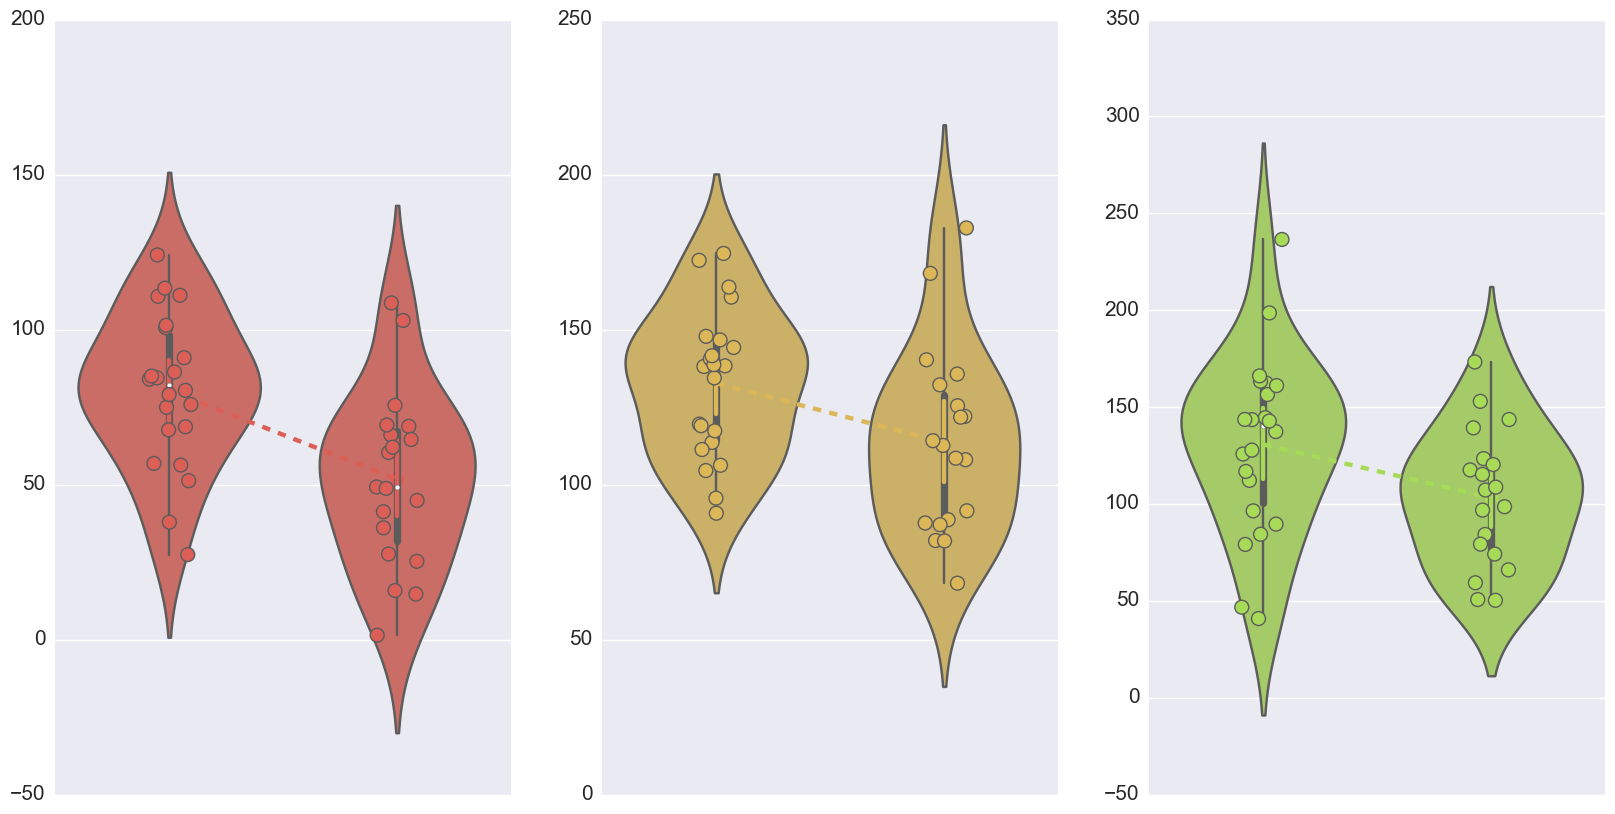

In [13]:
make_plot(controls_a,patients_a,m1 = 'STN', m2 = 'SN', m3 = 'RN')#, save = 'nucleus_stats_1.png')

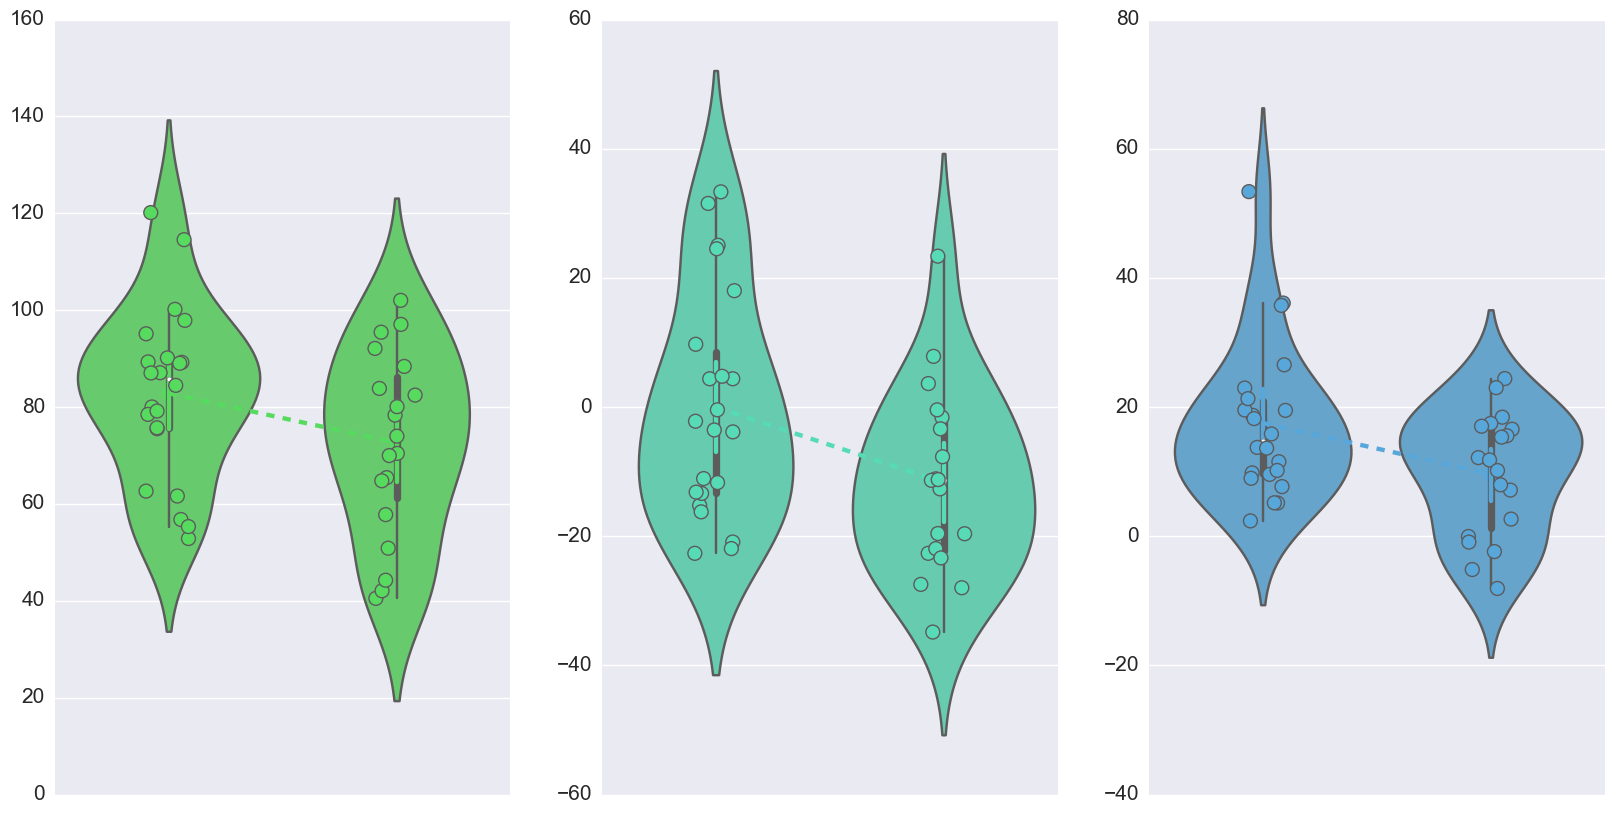

In [14]:
make_plot(controls_a,patients_a,m1 = 'Pall', m2 = 'Puta', m3 = 'Caud', pal=[3,6])#, save = 'nucleus_stats_2.png')

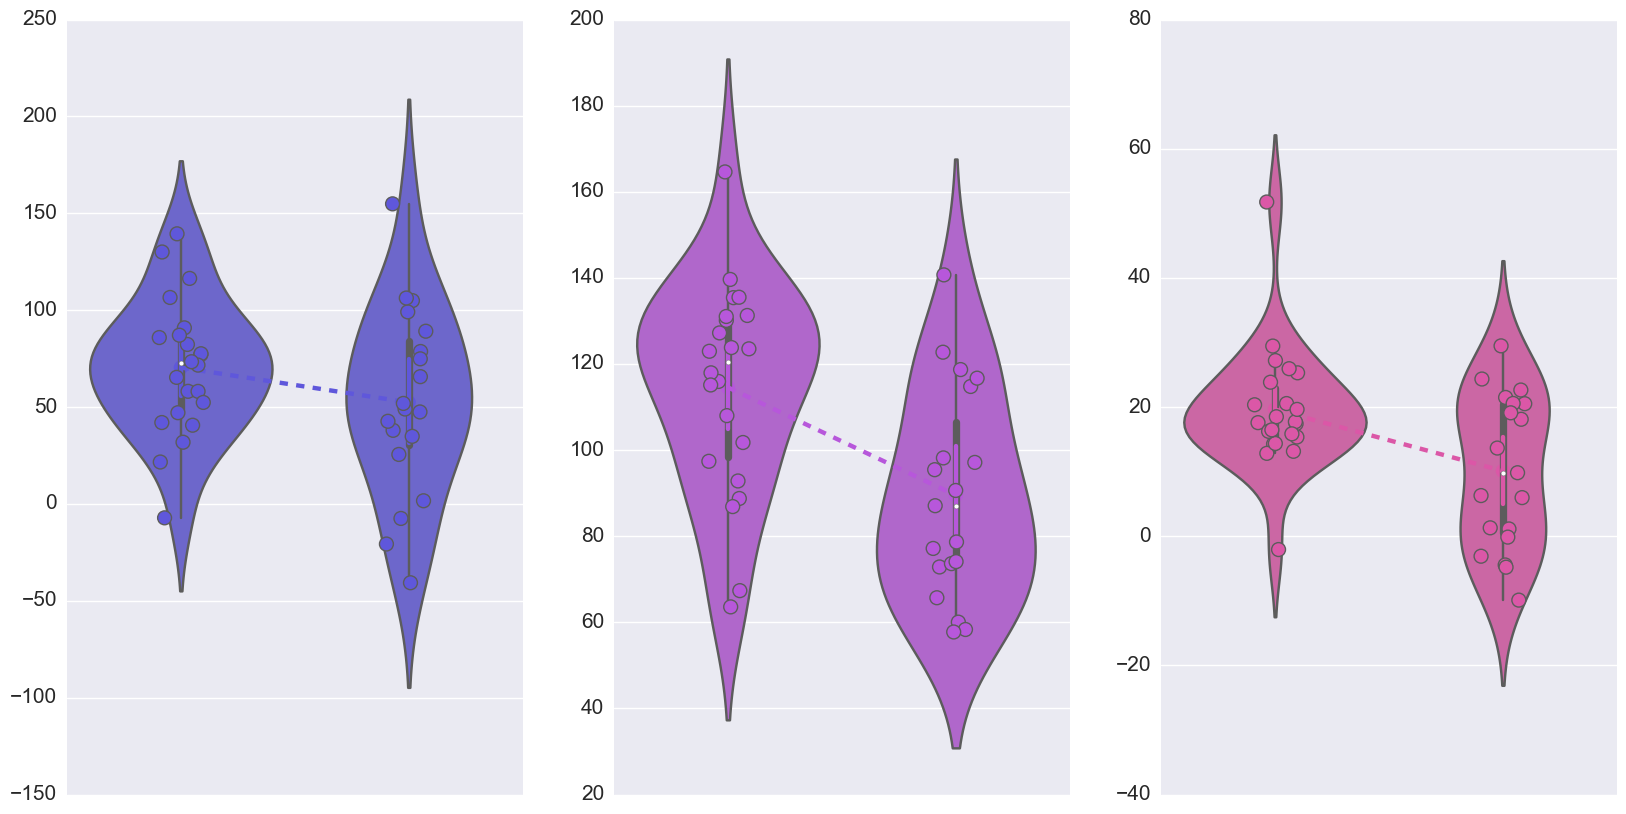

In [15]:

make_plot(controls_a,patients_a,m1 = 'DN', m2 = 'BrainStem', m3 = 'BasalGanglia', pal=[6,9])#,save = 'nucleus_stats_3.png')

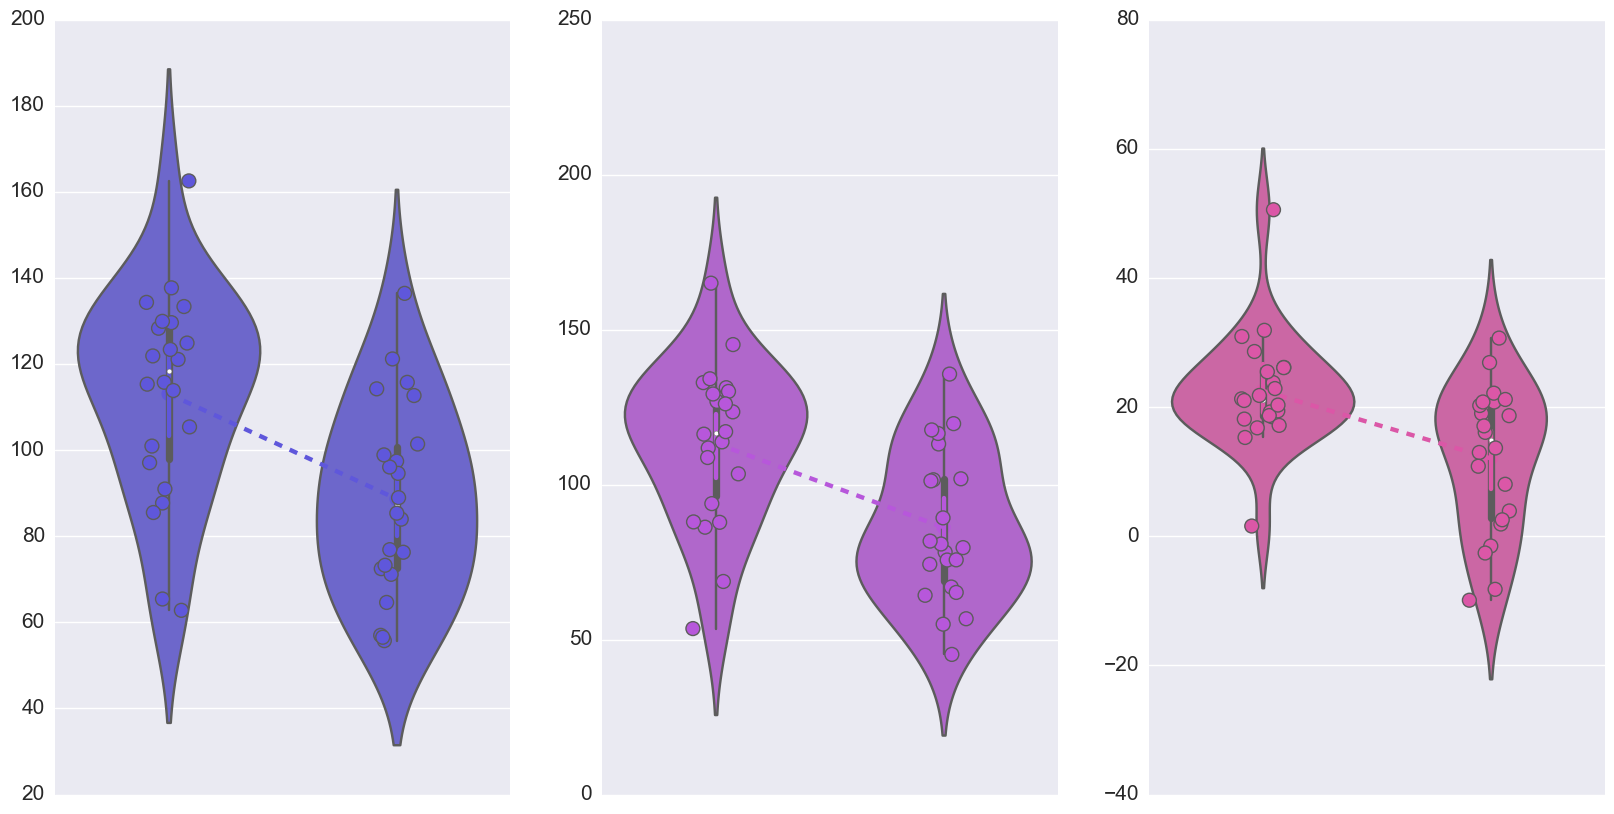

In [159]:
make_plot(controls_a,patients_a,m1 = 'BrainStem', m2 = 'LBrainStem', m3 = 'LBasalGanglia', pal=[6,9])

In [160]:
def make_plot_all(df1,df2, m, pal= [0,3], save = None):
    sns.set(font_scale=1.5)
    sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
    f, (ax1,ax2,ax3,ax4,ax5,ax6)= plt.subplots(nrows = 1, ncols = 6)
    f.set_size_inches([40,10])
    pallete = sns.color_palette("hls", 6)#[pal[0]:pal[1]]
    x = 1000
                
    def make_multiplot(m,  pallete, ax, jitter = 0.1, font=30):   
        data = [df1[m]*x, df2[m]*x] 
        g = sns.violinplot( data = data, color = pallete, ax = ax,whis= 1)#, scale='count')
        g = sns.stripplot(data=data, color = pallete, jitter= jitter, ax = ax, size = 10, linewidth=1)
        g = sns.pointplot(data=data, color = pallete, linestyles=['--'], markers=['o'], ax =ax)
        #g.legend([m], fontsize = 30 , handlelength=0, loc = 2)
        g.set(xticklabels=[])  
        def annot_datapoints(df, m, xr, alpha = 0.2, ax = ax):
            for i,s in zip(df[m]* x, df.index):
                ann = ax.annotate('%s'%s, xy= (xr,i), size= 15, color='b', alpha = alpha)
        
        #annot_datapoints(df1,m, -0.4)
        #annot_datapoints(df2,m, 0.4)
        #g.set(ylim=(-50, 300))

    make_multiplot(m[0], pallete[0], ax1)
    make_multiplot(m[1], pallete[1], ax2)
    make_multiplot(m[2], pallete[2], ax3)
    make_multiplot(m[3], pallete[3], ax4)
    make_multiplot(m[4], pallete[4], ax5)
    make_multiplot(m[5], pallete[5], ax6)
    
    fname = os.path.join(savefigdir, 'stats_all.png')
    f.savefig(fname , dpi = 300, bbox_inches='tight', transparent = False)

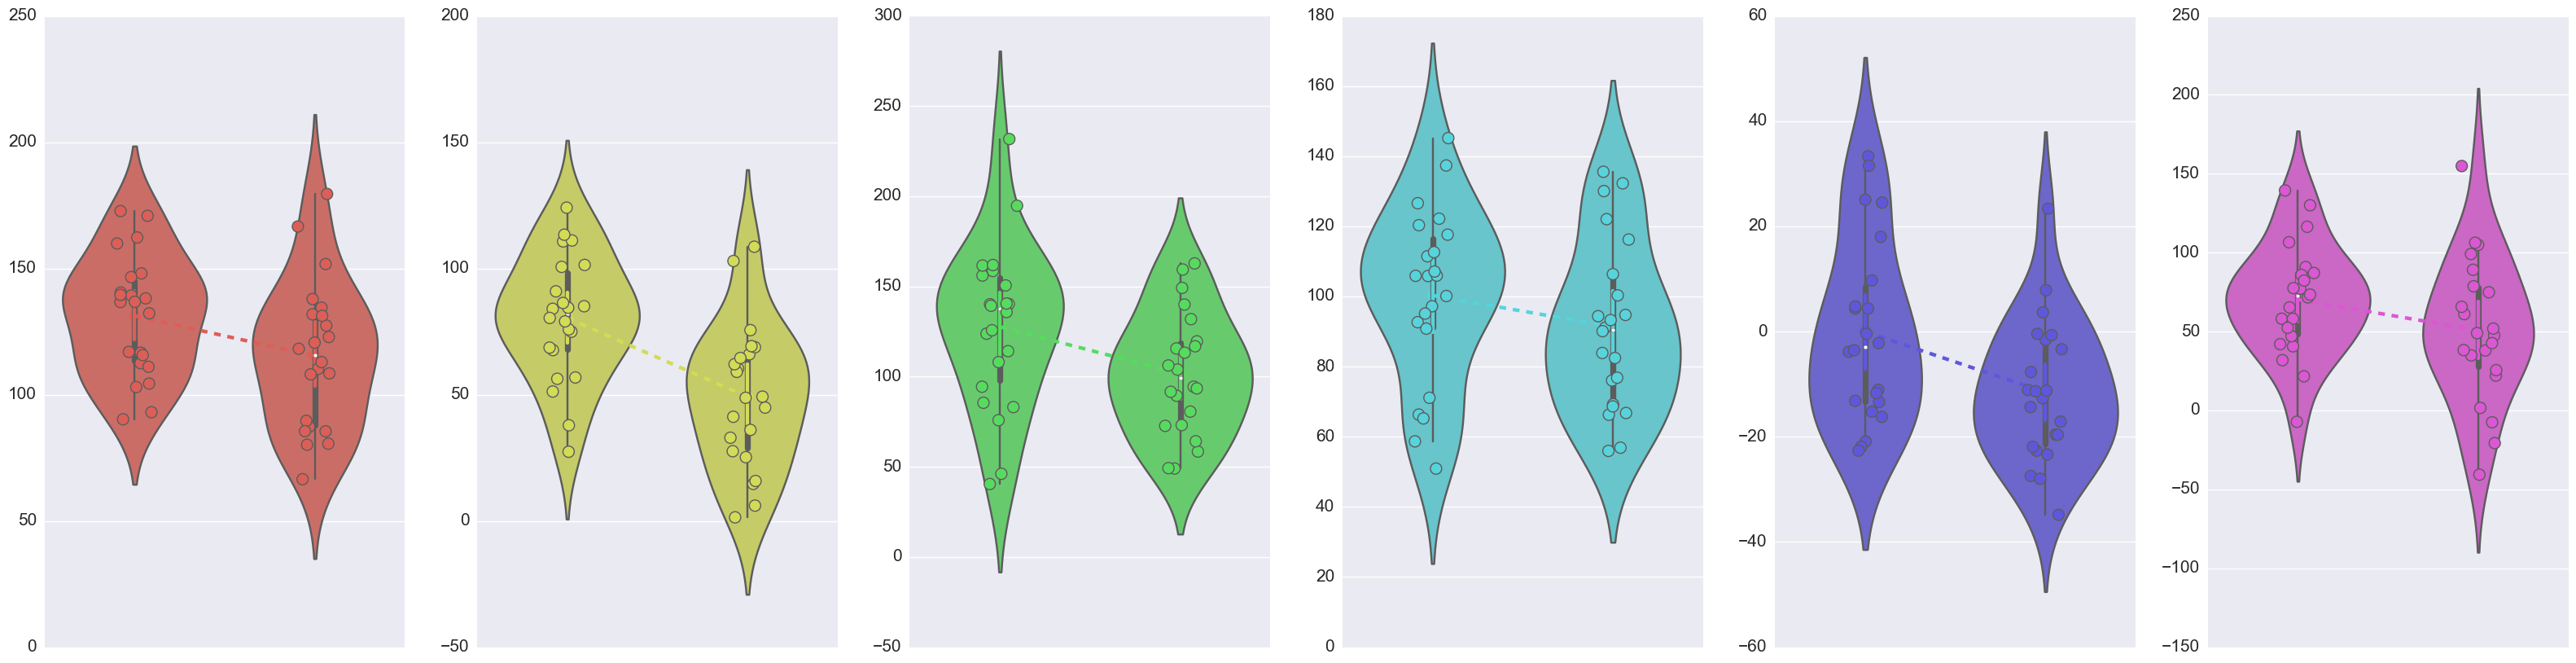

In [161]:
nuclei  = ['SN', 'STN', 'RN','GPi','Puta','DN']
make_plot_all(controls_a,patients_a,nuclei)

In [11]:
controls_a.

SMVX   -0.023371
SS1X   -0.020918
STQT   -0.023710
HM1X   -0.017276
TR4T   -0.024085
FA2T   -0.030998
PAHT    0.003658
GSNT   -0.039818
RJJT   -0.030404
KO4T   -0.016297
SDCT   -0.029490
HM2X   -0.022013
MJBT   -0.018431
GHAT   -0.005738
EC9T   -0.024043
RA7T   -0.014716
PU2T   -0.008186
TJ5T   -0.011709
BH5T   -0.004872
LMIT   -0.005305
TV1T   -0.021997
RMNT   -0.038016
Name: Hipp, dtype: float64